# Chapter 8 - Tree-based Methods

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.style.use('seaborn-white')

  **12. Apply boosting, bagging, and random forests to a data set of your choice. Be sure to fit the models on a
      training set and to evaluate their performance on a test set. How accurate are the results compared to simple 
      methods like linear or logistic regression? Which of these approaches yields the best performance?**

I will use the Hitters dataset to predict salary.

In [50]:
data=pd.read_csv('../Data/Hitters.csv').dropna()
data.drop(data.columns[0], axis=1, inplace=True) #Drop name variable
#Convert categorical string data to be coded as integers
data.League= pd.Categorical(data.League)
data.League = data.League.cat.codes
data.Division= pd.Categorical(data.Division)
data.Division = data.Division.cat.codes
data.NewLeague= pd.Categorical(data.NewLeague)
data.NewLeague = data.NewLeague.cat.codes
pd.set_option("display.max_rows", 25)
data.head(1000)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,1,0,325,9,3,700.0,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0,0,313,381,20,875.0,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,0,1,37,113,7,385.0,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,0,0,1314,131,12,960.0,0


We will log transform the salary. This is because there are a small number of extremely large salaries, and since we will be minimizing the squared error these might have a very high influence. By logging we will reduce the impact these large observations will have, which might improve performance since they amount to a very small amount of the total observations.

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague,Log(Salary)
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,1,6.163315
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,0,6.173786
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,1,6.214608
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,1,4.516339
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,0,6.620073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,1,0,325,9,3,1,6.551080
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,0,0,313,381,20,0,6.774224
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,0,1,37,113,7,0,5.953243
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,0,0,1314,131,12,0,6.866933


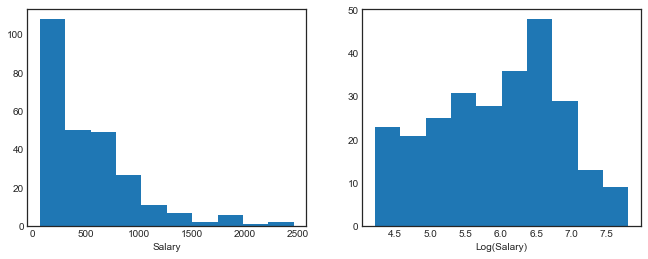

In [51]:

X = data[['Years', 'Hits']].to_numpy()
y = np.log(data.Salary.to_numpy())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(data.Salary.to_numpy())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

data = data.drop('Salary', axis=1)
data['Log(Salary)'] = y
data.head(1000)

In [20]:
#Create the train and validation set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Log(Salary)', axis=1), y, test_size=0.3, random_state=0
)

#### Boosting:

    We want to select the following parameters:
        1) The number of trees to be used. 
        2) The learning rate/ shrinkage parameter. 
        3) The number splits in each tree. 
    
    We can select these paramters by testing different ones, with 5-folds crossvalidation. GridsearchCV helps us 
    with this.

In [21]:
param_grid={
    'n_estimators':[20,50,100,200,300,400,500], 
    'learning_rate': [0.001,0.005,0.01, 0.015, 0.02],
    'max_depth':[1, 2, 3, 4] 
 } 

estimator = GradientBoostingRegressor()
boost_reg = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1)
boost_reg.fit(X_train, y_train)
print("Best parameters: ")
boost_reg.best_params_

Best parameters: 


{'learning_rate': 0.015, 'max_depth': 2, 'n_estimators': 200}

It seems as the above paramters will provide the best results. Let's calculate the training and test scores for this model.

In [22]:
yTrainPredicted, yTrainTrue = boost_reg.predict(X_train), y_train
train_MSE = mean_squared_error(yTrainTrue, yTrainPredicted)
print("Training MSE Score: %0.4f"%(train_MSE))

yTestPredicted, yTestTrue = boost_reg.predict(X_test), y_test
test_MSE = mean_squared_error(yTestTrue, yTestPredicted)
print("Testing MSE Score: %0.4f"%(test_MSE))

print()

trainR2Score = boost_reg.score(X_train, y_train)
print("Training R2 Score: %0.4f"%(trainR2Score))

testR2Score = boost_reg.score(X_test, y_test)
print("Testing R2 Score: %0.4f"%(testR2Score))

Training MSE Score: 0.1210
Testing MSE Score: 0.1650

Training R2 Score: 0.8410
Testing R2 Score: 0.8054


#### Bagging:

We could use Out-of-Bag Error Estimation for this but we will be using the MSE and R2 score to test vs. the different models

In [23]:
param_grid={
    'n_estimators':[600], 
    #The number of estimators (trees) just needs to be sufficiently large, it won't overfit.
    #We either try plotting the error for different number of estimators or just put a large number.
    #We put a large number for simplicity
    'max_samples' : [0.05, 0.1, 0.2, 0.5, 0.75, 1.0] #Different proportions of samples to use for bootstraping
 } 

estimator = BaggingRegressor()
bag_reg = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1)
bag_reg.fit(X_train, y_train)
print("Best parameters: ")
bag_reg.best_params_

Best parameters: 


{'max_samples': 0.2, 'n_estimators': 600}

In [24]:
yTrainPredicted, yTrainTrue = bag_reg.predict(X_train), y_train
train_MSE = mean_squared_error(yTrainTrue, yTrainPredicted)
print("Training MSE Score: %0.4f"%(train_MSE))

yTestPredicted, yTestTrue = bag_reg.predict(X_test), y_test
test_MSE = mean_squared_error(yTestTrue, yTestPredicted)
print("Testing MSE Score: %0.4f"%(test_MSE))

print()

trainR2Score = bag_reg.score(X_train, y_train)
print("Training R2 Score: %0.4f"%(trainR2Score))

testR2Score = bag_reg.score(X_test, y_test)
print("Testing R2 Score: %0.4f"%(testR2Score))

Training MSE Score: 0.1664
Testing MSE Score: 0.1684

Training R2 Score: 0.7814
Testing R2 Score: 0.8014


According to testing scores the boosting method performs marginally better than the bagging method. This was also expected since it is a more robust algorithm which generally yields better results.

### Random forest:

In [15]:
# There are 19 features in the dataset
X_train.shape

(184, 19)

In [25]:
param_grid={
    'n_estimators':[600], #The number of estimators (trees) just needs to be sufficiently large, it won't overfit.
    'max_features': [1,2,3,4,5,8,11,15,17],  #Max number of features to use for each split. 19 would equal bagging
    'max_samples' : [0.05, 0.1, 0.2, 0.5, 0.75, 1.0], #Different proportions of samples to use for bootstraping
 } 

estimator = RandomForestRegressor()
rf_reg = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1)
rf_reg.fit(X_train, y_train)
print("Best parameters: ")
rf_reg.best_params_

Best parameters: 


{'max_features': 3, 'max_samples': 0.5, 'n_estimators': 600}

In [26]:
yTrainPredicted, yTrainTrue = rf_reg.predict(X_train), y_train
train_MSE = mean_squared_error(yTrainTrue, yTrainPredicted)
print("Training MSE Score: %0.4f"%(train_MSE))

yTestPredicted, yTestTrue = rf_reg.predict(X_test), y_test
test_MSE = mean_squared_error(yTestTrue, yTestPredicted)
print("Testing MSE Score: %0.4f"%(test_MSE))

print()

trainR2Score = rf_reg.score(X_train, y_train)
print("Training R2 Score: %0.4f"%(trainR2Score))

testR2Score = rf_reg.score(X_test, y_test)
print("Testing R2 Score: %0.4f"%(testR2Score))

Training MSE Score: 0.0914
Testing MSE Score: 0.1478

Training R2 Score: 0.8799
Testing R2 Score: 0.8258


The random forest method in this case performs better than boosting (and also bagging, which is expected since random forest is an improved version of bagging, where the trees are decorrelated by limiting which predictors can be picked for each split). 

Now let's compare this result to a linear regression model which uses the same dataset:


### Linear regression:

In [29]:
lin_reg = LinearRegression().fit(X_train, y_train)

yTrainPredicted, yTrainTrue = lin_reg.predict(X_train), y_train
train_MSE = mean_squared_error(yTrainTrue, yTrainPredicted)
print("Training MSE Score: %0.4f"%(train_MSE))

yTestPredicted, yTestTrue = lin_reg.predict(X_test), y_test
test_MSE = mean_squared_error(yTestTrue, yTestPredicted)
print("Testing MSE Score: %0.4f"%(test_MSE))

print()

trainR2Score = lin_reg.score(X_train, y_train)
print("Training R2 Score: %0.4f"%(trainR2Score))

testR2Score = lin_reg.score(X_test, y_test)
print("Testing R2 Score: %0.4f"%(testR2Score))

Training MSE Score: 0.3412
Testing MSE Score: 0.4312

Training R2 Score: 0.5517
Testing R2 Score: 0.4916


It is apparent that in this case the underlying distribution of the data is not linear, due to the poor results. Of course the linear model would be able to be improved using feature selection methods but it is clear that methods such as random forests or boosting are more robust. 


### Conclusions

I did not have time to try out random forests/boosting for classification, but it is easily done in the same was as regression in python. Sklearn provides packages for this which are used in the same way. Of course then I would also need to use other performance measures than R2 or MSE, but those are also easily calculated.

I found tree based methods to be very interesting. In particular, it is very good that they can be easily understood. For example, we can plot the importance of the features used, as well as their decision trees. Let's do that for our random forest model.

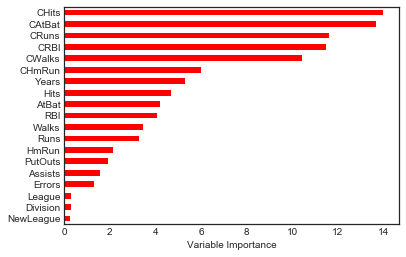

In [38]:
rf_estimator = rf_reg.best_estimator_
Importance = pd.DataFrame({'Importance':rf_estimator.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In order to visualise the random forest we have to extract one of the decision trees in the random forest. These trees will be a little bit different from each other, so in order to get the full picture one would have to make one graph for each one. But generally you can choose only one or a few trees to visualize. Since we have 600 different ones in our tree we will just show the first one.

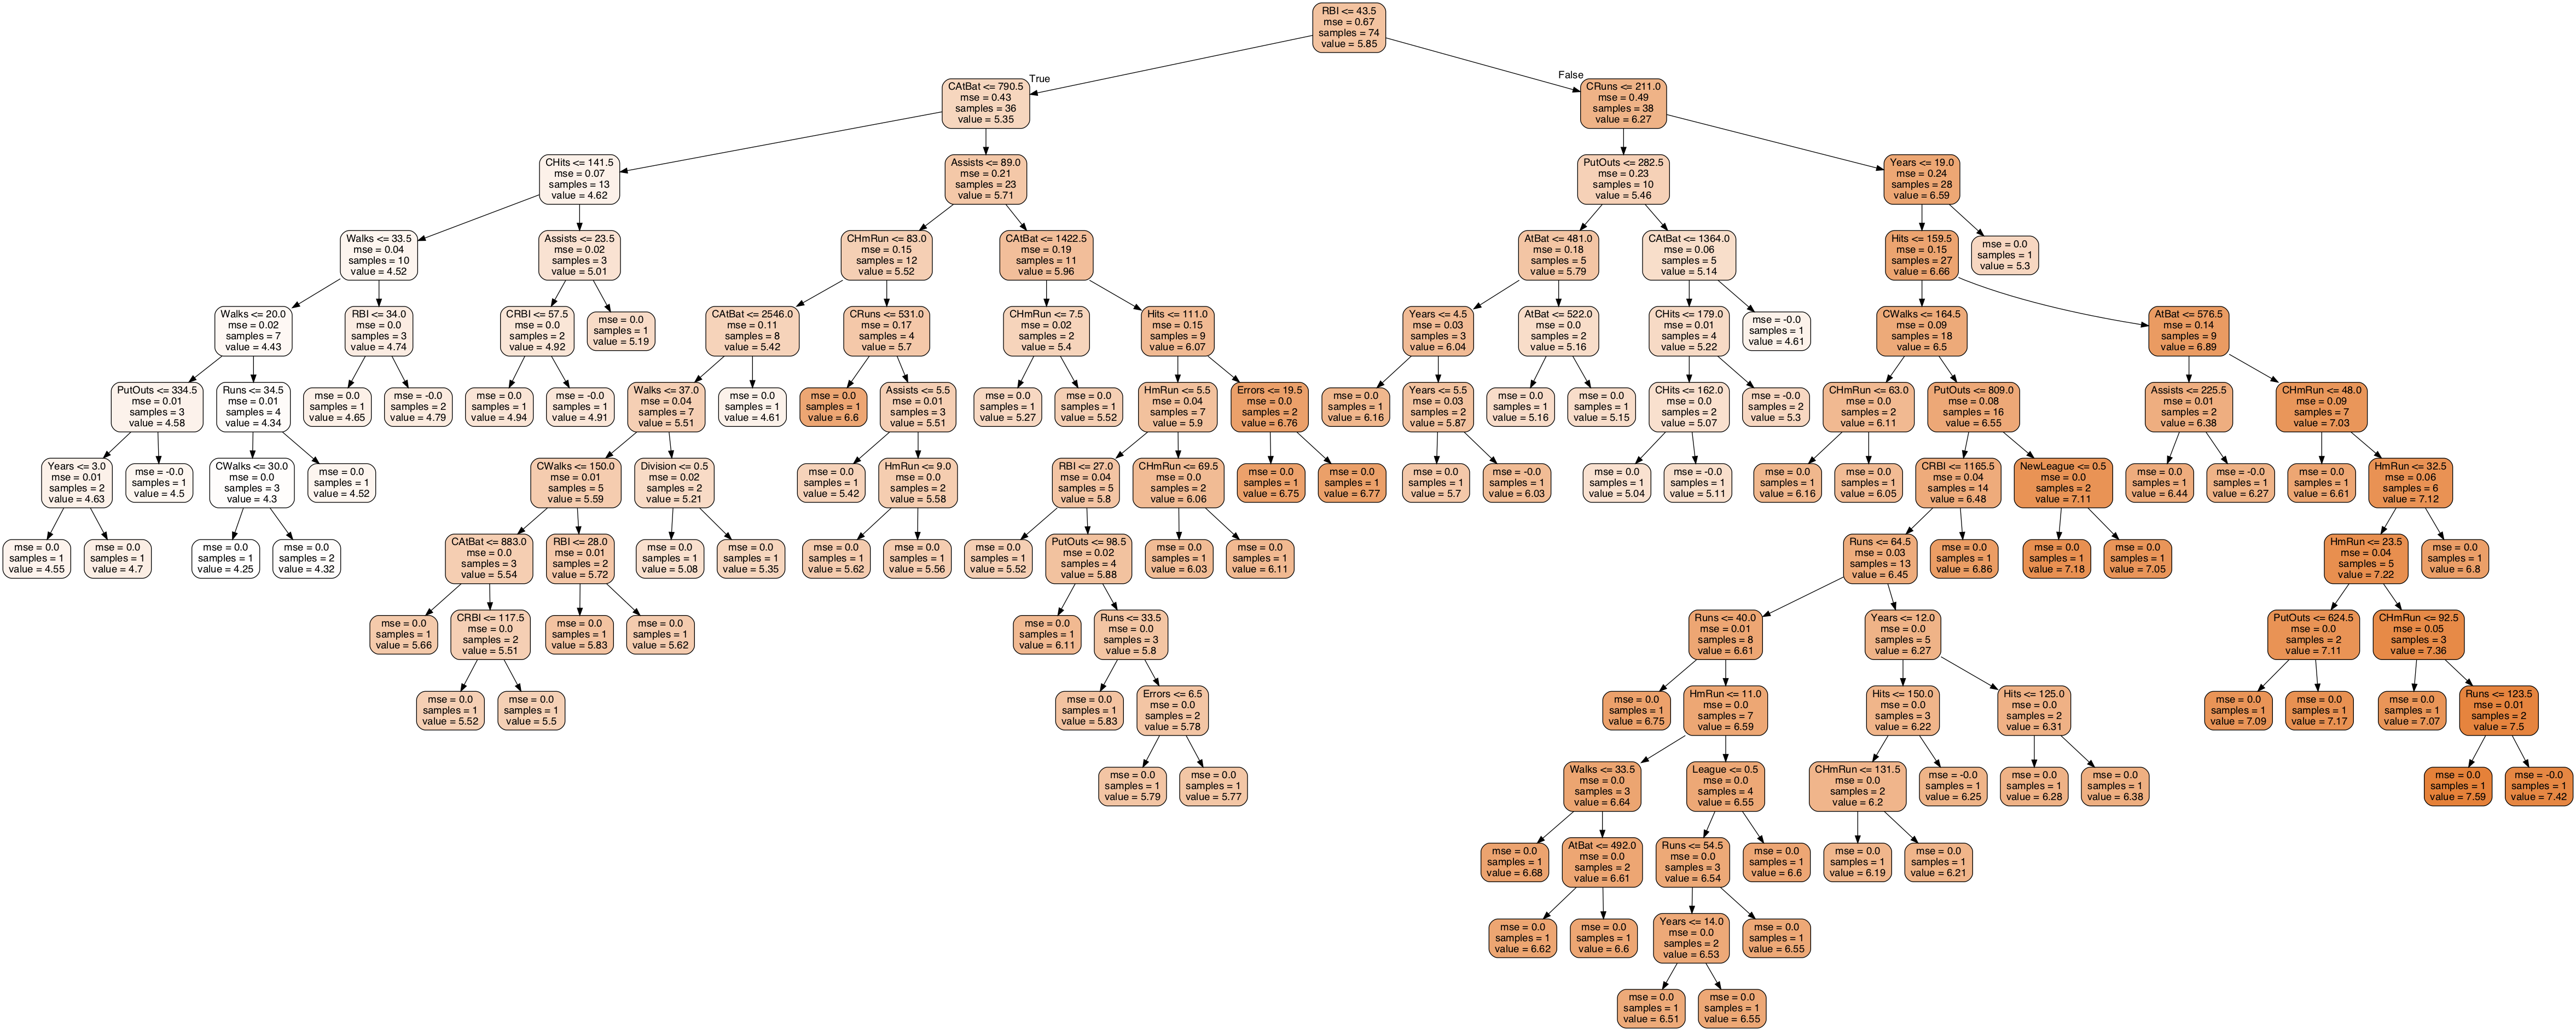

In [49]:
# Extract single tree
estimator = rf_estimator.estimators_[0] #pick a random estimator

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['Log(Salary)'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

By using these methods our model can easily be explored and understood, even for someone who does not understand the underlying mathematical concepts. This makes tree based methods a very powerful tool.